# Analysing topics of speeches in the German Bundestag

## Get data from BT API

In [1]:
#import libraries
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [2]:
BT_protocols=list() # collected documents

parameters = {"apikey": "rgsaY4U.oZRQKUHdJhF9qguHMkwCGIoLaqEcaHjYLF", "f.wahlperiode": 20, "f.zuordnung": "BT", "format": "json"} # parameters for API requests

while 1:
    # get document from API (API only allows retrieval of 10 entities at a time)
    response = requests.get("https://search.dip.bundestag.de/api/v1/plenarprotokoll-text", params=parameters)
    BT_protocols.extend(response.json()["documents"])

    # update cursor for next API request
    if "cursor" in parameters:
        if parameters["cursor"] == response.json()["cursor"]:
            break # exit when cursor position does not change (all documents retrieved)
        else:
            parameters["cursor"] = response.json()["cursor"]
    else:
        parameters["cursor"] = response.json()["cursor"]

# convert to pandas dataframe only retaining relevant features
BT_protocols=pd.DataFrame(BT_protocols)
BT_protocols.reindex(columns=["id", "dokumentnummer","datum","text"])

,id,dokumentnummer,datum,text
0,5585,20/116,2023-07-07,Deutscher Bundestag\nStenografischer Bericht\n...
1,5584,20/115,2023-07-06,Deutscher Bundestag\nStenografischer Bericht\n...
2,5583,20/114,2023-07-05,Deutscher Bundestag\nStenografischer Bericht\n...
3,5582,20/113,2023-06-23,Deutscher Bundestag\nStenografischer Bericht\n...
4,5581,20/112,2023-06-22,Deutscher Bundestag\nStenografischer Bericht\n...
...,...,...,...,...
111,5444,20/5,2021-12-08,[Deutscher Bundestag\nStenografischer Bericht\...
112,5443,20/4,2021-12-07,[Deutscher Bundestag\nStenografischer Bericht\...
113,5435,20/3,2021-11-18,[Deutscher Bundestag\nStenografischer Bericht\...
114,5434,20/2,2021-11-11,[Deutscher Bundestag\nStenografischer Bericht\...


## Preprocessing

In [3]:
#import libraries
import unicodedata
import nltk
import string
import re
from nltk import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# lower case via the lower() built-in method
docs = [s.lower() for s in BT_protocols["text"]]
docs[0][0:200]

'deutscher bundestag\nstenografischer bericht\n116. sitzung\nberlin, freitag, den 7. juli 2023\ni n h a l t :\nänderung der tagesordnung . . . . . . . . . . . . . . . . . 14311 b\nabsetzung des tagesordnungs'

In [6]:
# remove text before protocol starts and
docs = [d[d.find("beginn:"):d.rfind("anlagen zum stenografischen bericht")] for d in docs]
print(docs[0][0:50])
print("\n--------------\n")
print(docs[0][-50:])

beginn: 9.00 uhr
präsidentin bärbel bas:
sehr geeh

--------------

die sitzung ist geschlossen.
(schluss: 16.33 uhr)



In [ ]:
#contractions?
# document-specific stop words (names, terms(Beifall))

In [7]:
# clean text
def clean_text(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE) # convert multiple white spaces to single white space
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE) # remove non-ascii characters preserving German special characters, remove digits, remove punctuation
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE) # remove single chars

    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    return text

# apply function
docs = [clean_text(d) for d in docs]
docs[0][0:200]

'beginn uhr präsidentin bärbel bas sehr geehrte damen und herren liebe kolleginnen und kollegen ich wünsche ihnen allen einen wunderschönen guten morgen die sitzung ist eröffnet ich teile ihnen mit das'

In [8]:
#tokenize
tokens = [word_tokenize(d) for d in docs]
tokens[0][0:20]

['beginn',
 'uhr',
 'präsidentin',
 'bärbel',
 'bas',
 'sehr',
 'geehrte',
 'damen',
 'und',
 'herren',
 'liebe',
 'kolleginnen',
 'und',
 'kollegen',
 'ich',
 'wünsche',
 'ihnen',
 'allen',
 'einen',
 'wunderschönen']

In [9]:
# remove stopwords
stop_words = set(stopwords.words("german"))

def remove_stopwords(tokens, stopwords):
    return [t for t in tokens if t not in stopwords]

# apply stopword removal function
tokens = [remove_stopwords(t, stopwords=stop_words) for t in tokens]
tokens[0][0:20]

['beginn',
 'uhr',
 'präsidentin',
 'bärbel',
 'bas',
 'geehrte',
 'damen',
 'herren',
 'liebe',
 'kolleginnen',
 'kollegen',
 'wünsche',
 'wunderschönen',
 'guten',
 'morgen',
 'sitzung',
 'eröffnet',
 'teile',
 'ältestenrat',
 'gestrigen']

In [10]:
#stem words - outdated, use lemmas now
stemmer = SnowballStemmer("german")

def stem(tokens):
    """stem all tokens that do not contain hyphens"""
    return [stemmer.stem(t) for t in tokens]

# apply function
stems = [stem(t) for t in tokens]
stems[0][0:20]

['beginn',
 'uhr',
 'prasidentin',
 'barbel',
 'bas',
 'geehrt',
 'dam',
 'herr',
 'lieb',
 'kolleginn',
 'kolleg',
 'wunsch',
 'wunderschon',
 'gut',
 'morg',
 'sitzung',
 'eroffnet',
 'teil',
 'altestenrat',
 'gestrig']

In [14]:
# lemmatize with standard spaCy lemmatizer (takes around 12 min)
!python -m spacy download de_core_news_sm

import spacy

nlp_standard = spacy.load('de_core_news_sm')
def lemmatize_sent(sent):
    sent = ' '.join(sent)
    doc = nlp_standard(sent)
    lemmas = [token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc]
    return lemmas

# apply function
lemmas = [lemmatize_sent(t) for t in tokens]

2023-07-16 15:05:58.679460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 70.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


AttributeError: ignored

In [17]:
lemmas = [[lem.lower() for lem in lem_doc] for lem_doc in lemmas] # lower case tokens (again)
lemmas[0][0:20]

['beginn',
 'uhr',
 'präsidentin',
 'bärbel',
 'bas',
 'geehrt',
 'dam',
 'herr',
 'lieb',
 'kolleginn',
 'kollege',
 'wünsche',
 'wunderschön',
 'gut',
 'morgen',
 'sitzung',
 'eröffnen',
 'teil',
 'ältestenrat',
 'gestrig']

In [18]:
# exclude terms based on tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer

# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

# generate document frequency ranking for all terms in the vocabulary
vectorizer = TfidfVectorizer(use_idf=False, norm=None, tokenizer=do_nothing, preprocessor=do_nothing)
df_matrix = vectorizer.fit_transform(lemmas).toarray()
df_matrix_bool = np.where(df_matrix > 0, 1, 0)
scores_df = df_matrix_bool.sum(axis=0)

sorted_vocab = sorted(vectorizer.vocabulary_.items(),   key=lambda x: x[1])
sorted_vocab_keys = list(np.array(sorted_vocab)[:,0])
sorted_scores_df = sorted(set(scores_df), reverse=True)

rank_dict = {k:val for k,val in zip(sorted_scores_df, list(range(len(sorted_scores_df))))}
rank_tup = sorted(zip(scores_df, sorted_vocab_keys),  key=lambda x: x[0], reverse=True)
df_ranking = [x + (rank_dict[x[0]],) for x in rank_tup]
df_ranking[:10]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[(116, '--', 0),
 (116, 'abg', 0),
 (116, 'abgeordneter', 0),
 (116, 'afd', 0),
 (116, 'arbeit', 0),
 (116, 'aufgabe', 0),
 (116, 'beginn', 0),
 (116, 'bei', 0),
 (116, 'beifall', 0),
 (116, 'bekannt', 0)]

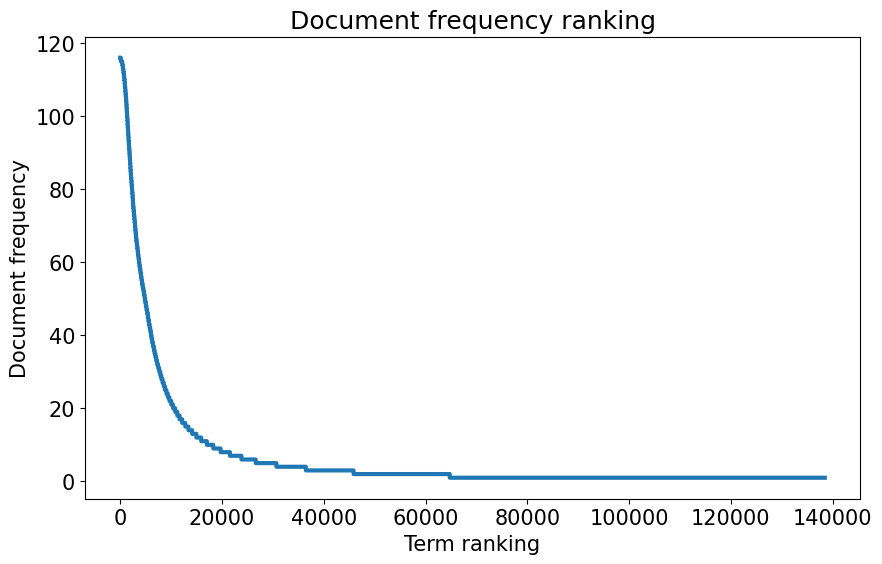

In [44]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 15

# plot document frequency
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in df_ranking])
plt.title('Document frequency ranking')
plt.ylabel("Document frequency")
plt.xlabel("Term ranking")
plt.show()

In [45]:
# function to compute term-frequency inverse document frequency
def tf_idf_compute(term, num_docs, scores_tf, scores_df):
    return (1+np.log(scores_tf[term])*np.log(num_docs/scores_df[term]))

# generate term frequency inverse document frequency ranking for all terms in the vocabulary
sorted_vocab = sorted(vectorizer.vocabulary_.items(),   key=lambda x: x[1])
sorted_vocab = list(np.array(sorted_vocab)[:,0])
scores_tf = df_matrix.sum(axis=0)
scores_tfidf = [tf_idf_compute(t, len(tokens), scores_tf=scores_tf, scores_df=scores_df) for t in range(len(sorted_vocab))]
sorted_scores_tfidf = sorted(set(scores_tfidf), reverse=True)

rank_dict = {k:val for k,val in zip(sorted_scores_tfidf, list(range(len(sorted_scores_tfidf))))}
rank_tup = sorted(zip(scores_tfidf, sorted_vocab),  key=lambda x: x[0], reverse=True)
tfidf_ranking = [x + (rank_dict[x[0]],) for x in rank_tup]
tfidf_ranking[:10]

[(22.546120490866997, 'wi', 0),
 (19.69028776085893, 'plattdüütsch', 1),
 (18.415070705555372, 'imo', 2),
 (17.900667671065104, 'nagoya', 3),
 (17.00674442797707, 'vestas', 4),
 (16.91851328867892, 'ik', 5),
 (16.8279079346661, 'jehovas', 6),
 (16.365486349625616, 'progressionsvorbehalt', 7),
 (16.27213872103431, 'weddellmeer', 8),
 (16.19389161398322, 'unifil', 9)]

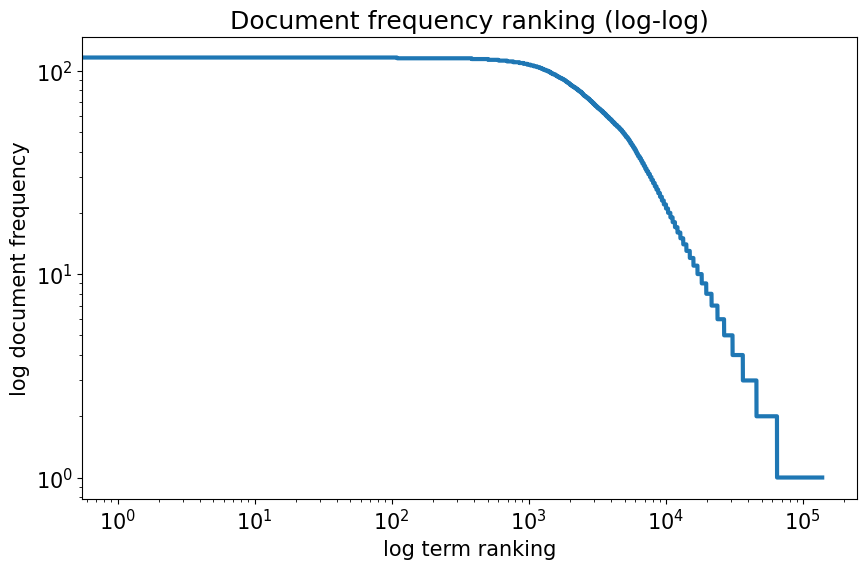

In [46]:
# plot tfidf ranking
plt.figure(figsize=(10,6))
plt.loglog([x[0] for x in df_ranking])
plt.title('Document frequency ranking (log-log)')
plt.ylabel("log document frequency")
plt.xlabel("log term ranking")
plt.show()

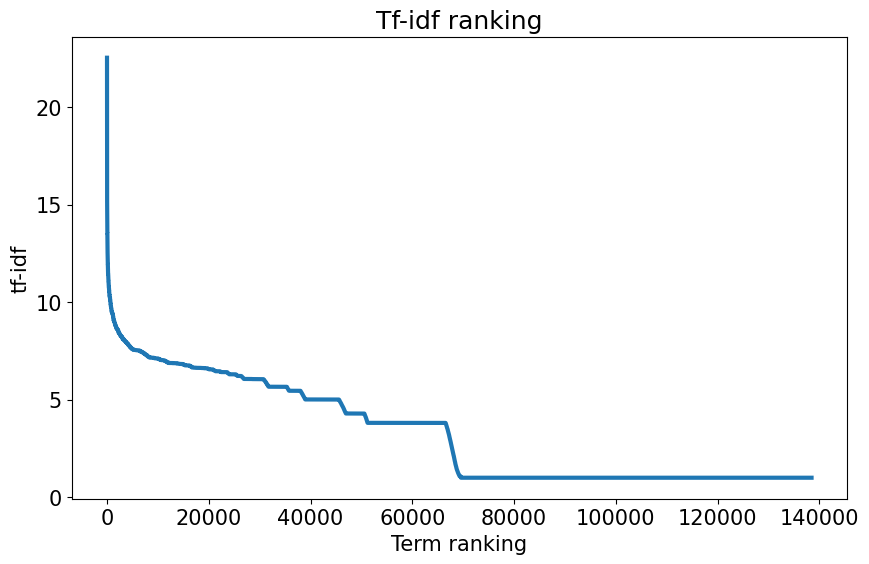

In [47]:
# plot tf-ids ranking
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in tfidf_ranking])
plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()

In [93]:
tfidf_ranking[52000][0]

3.8144846245845865

In [94]:
# auxiliary function to easily remove undesired tokens
def remove(tokens, to_remove):
    if to_remove:
        return [t for t in tokens if t not in to_remove]
    else:
        return tokens

# function to remove tokens in documents according to their df or tfidf score
def rank_remove(ranking, docs, min_cutoff_score=-np.inf, max_cutoff_score=np.inf):

    # define list of tokens to remove
    to_remove_low = set([t[1] for t in ranking if t[0] <= min_cutoff_score])
    to_remove_high = set([t[1] for t in ranking if t[0] > max_cutoff_score])

    # remove tokens
    docs_clean = [remove(d, to_remove_low) for d in docs]
    docs_clean = [remove(d, to_remove_high) for d in docs_clean]

    return docs_clean

# update documents
lemmas_clean = rank_remove(tfidf_ranking, lemmas, min_cutoff_score=tfidf_ranking[52000][0])

In [95]:
#create document-term matrix with selected lemmas
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(preprocessor=do_nothing,              # apply no additional preprocessing
                                   tokenizer=do_nothing,                 # apply no additional tokenization
                                   lowercase=False,                      # convert all characters to lower-case
                                   strip_accents=None,                   # remove non-ascii characters
                                   stop_words=None,                      # remove stopwords from a built-in list. We can also provide our own list
                                   ngram_range=(1, 1),                   # generate only unigrams
                                   analyzer='word',                      # analysis at the word-level
                                   max_df=1.0,                           # ignore tokens that have a higher document frequency (can be int or percent)
                                   min_df=0,                             # ignore tokens that have a lowe document frequency (can be int or percent)
                                   max_features=None,                    # we could impose a maximum number of vocabulary terms
                                   )

# create the document term matrix using lemmas
dt_matrix_lemmas = count_vectorizer.fit_transform(lemmas_clean).toarray()
print(dt_matrix_lemmas.shape)
print(dt_matrix_lemmas.dtype)
word2idx = count_vectorizer.vocabulary_
idx2word = {i:word for word,i in word2idx.items()}


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(116, 51177)
int64


## Fit topic model (LDA)

In [96]:
# create LDA object with our parameters
!pip3 install lda
import lda

num_topics = 30
vocab_size = dt_matrix_lemmas.shape[1]
lda_model = lda.LDA(n_topics=num_topics,         # Number of topics
                    alpha=50/num_topics,         # Dirichlet parameter for distribution over topics
                    eta=200/vocab_size,          # Dirichlet parameter for distribution over words
                    n_iter=5000,                 # Number of sampling iterations
                    random_state=92              # The generator used for the initial topics
                    )



# check some paramters
print(lda_model.alpha)
print(lda_model.eta)
print(lda_model.n_topics)

1.6666666666666667
0.00390800554936788
30


In [ ]:
# not applied
from sklearn.model_selection import GridSearchCV

T = np.arange(10,100,10)

parameters = {'n_topics': T}
GridSearchCV(lda_model, parameters, cv=20, verbose=1,
                       return_train_score=True, scoring='neg_mean_squared_error') # correct?

In [ ]:
# not applied
T = np.arange(10,100,10)

for it in T:
  lda_model[it] = lda.LDA(n_topics=T[it],         # Number of topics
                    alpha=50/T[it],         # Dirichlet parameter for distribution over topics
                    eta=200/vocab_size,          # Dirichlet parameter for distribution over words
                    n_iter=5000,                 # Number of sampling iterations
                    random_state=92              # The generator used for the initial topics
                    )

  lda_model[it].fit(dt_matrix_stems)

  # plot

In [97]:
# estimate model (takes around 20 minutes)
lda_model.fit(dt_matrix_lemmas)

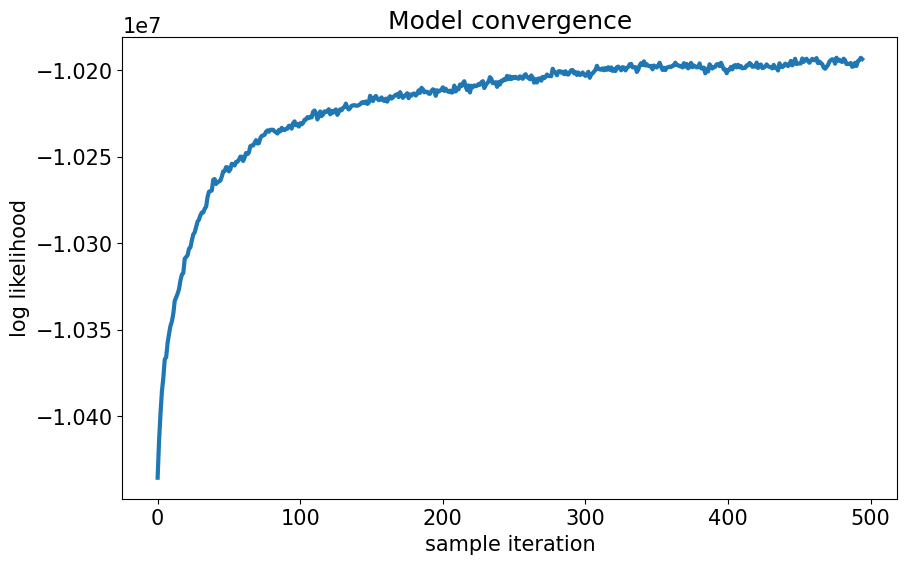

In [98]:
#check model convergence

plt.figure(figsize=(10,6))
plt.plot(lda_model.loglikelihoods_[5:])
plt.title('Model convergence')
plt.ylabel("log likelihood")
plt.xlabel("sample iteration")
plt.show()


In [100]:
# explore the words with highest probability per topic
topics_dist = lda_model.topic_word_
n_top_words = 15
for i, topic_dist in enumerate(topics_dist):
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    print('Topic {}: {}'.format(i, ' '.join(top_words)))

Topic 0: parl vizepräsident bundesminister nachfrag befragung beantwortung geschäftsbereich www schriftlich mercosur badum bayram fragesteller einleitend
Topic 1: bosnien kosovo herzegowina schweden suizid balkan vizepräsident finnland westbalkan kfor beitritt althea kroatien alleinerziehend
Topic 2: mandat mali soldatinn mission libanon libyen streitkraft minusma operation unifil abzug niger irini malisch
Topic 3: ticket öpnv verein donth autobahn bus journalist gelbhaar ebn deutschlandticket stahr nahverkehr frühkindlich mordhorst
Topic 4: mathias ingo fabian anna kerstin lehmann saskia beate mario rudolph lindholz andré dagmar bleck
Topic 5: petition sammelübersichen petitionsausschusses sammelübersicht sed petitionsausschuss diktatur aufarbeitung enquet stimmzettel telegram einstimmig ungültig ost
Topic 6: impfpflicht impfung impfen impfstoff welle virus maske omikron gesundheitssystem variante well infektionsschutzgesetz maskenpflicht ungeimpft
Topic 7: landwirt stegemann landwirt

In [101]:
!pip3 install wordcloud
from wordcloud import WordCloud

# define a set of colors for each topic
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
n_top_words = 15
# create a wordcloud object
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=n_top_words,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

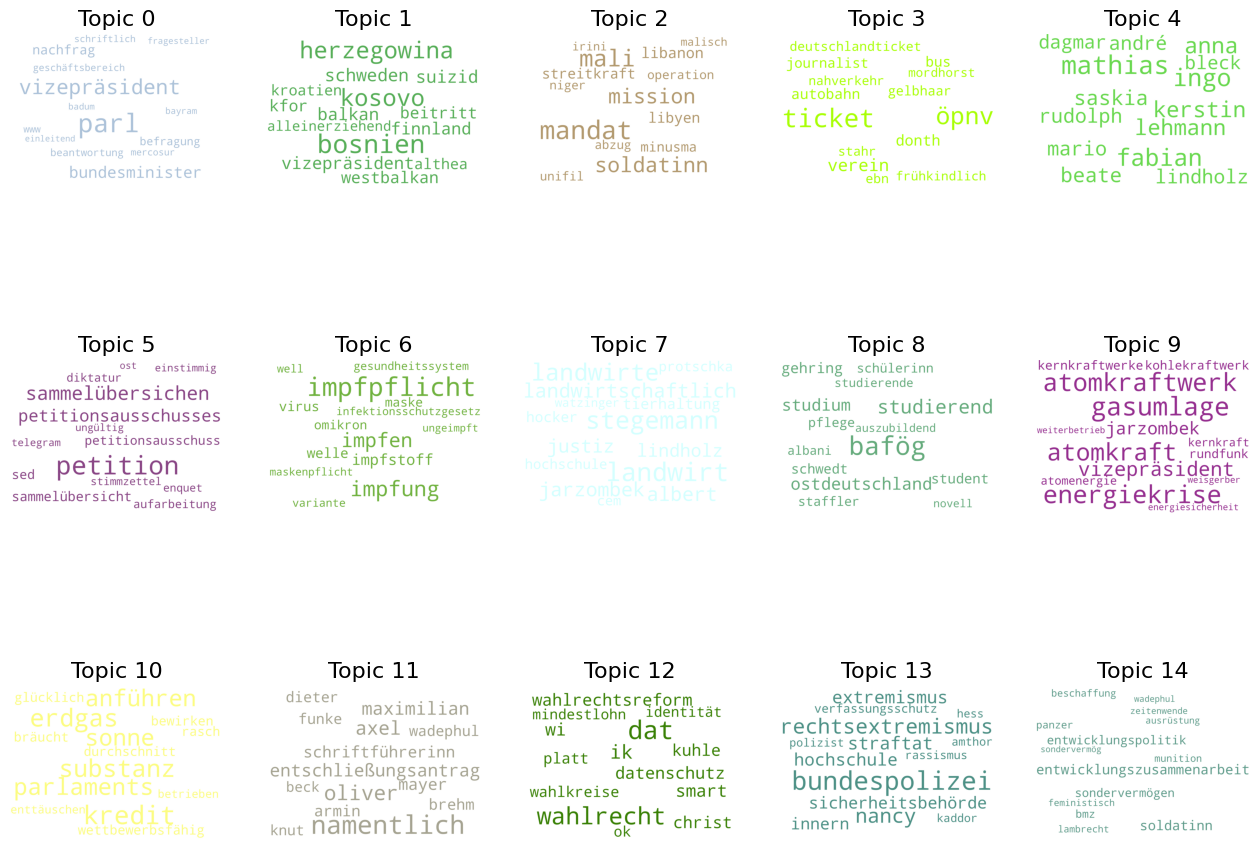

In [103]:
# create figure for the first 15 topics
!pip3 install wordcloud
from wordcloud import WordCloud

fig, axes = plt.subplots(3, 5, figsize=(16,12), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):

    # select top words from topic
    topic_dist = topics_dist[i]
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    top_probs = [topic_dist[idx] for idx in top_idxs]
    plot_dict = {top_words[i]:top_probs[i] for i in range(len(top_words))}

    # generate subplot
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(plot_dict, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

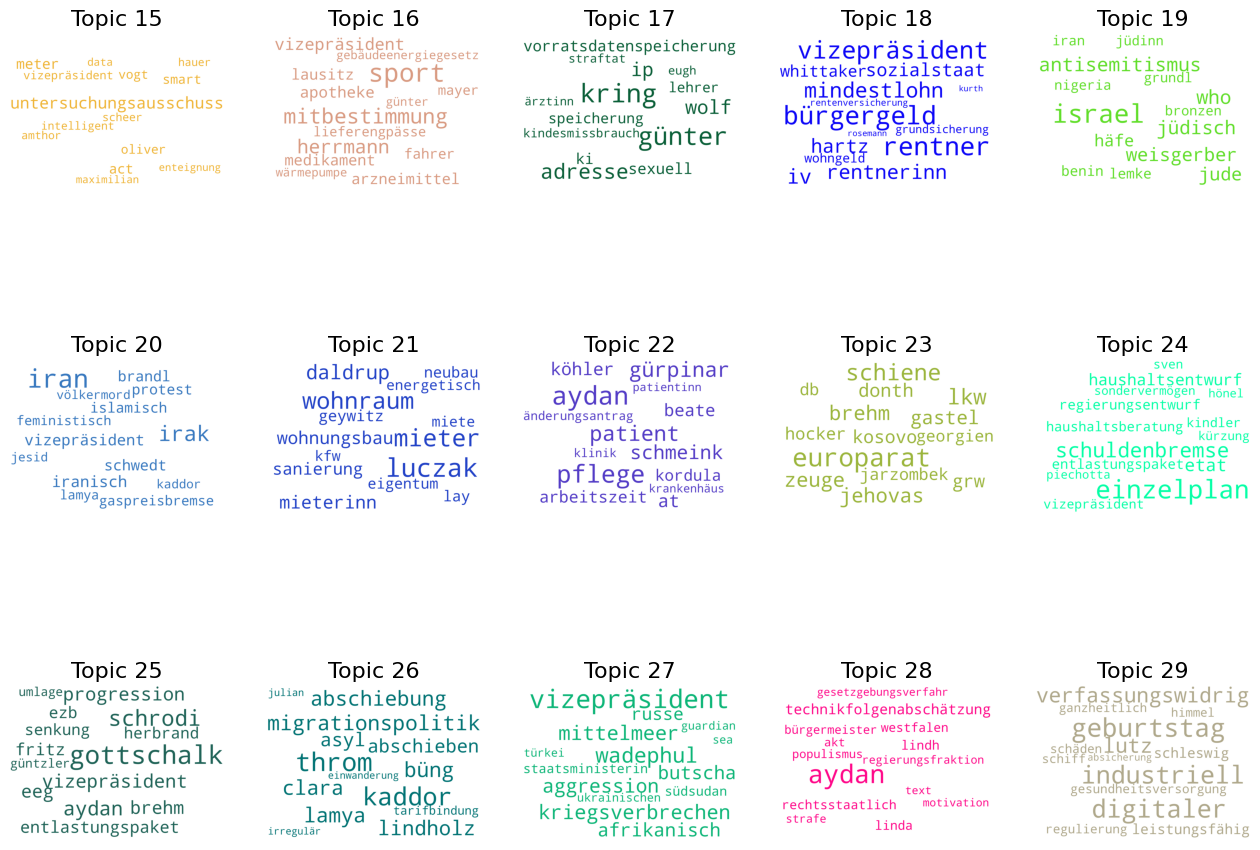

In [104]:
# create figure for the last 15 topics
fig, axes = plt.subplots(3, 5, figsize=(16,12), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten(), 15):

    # select top words from topic
    topic_dist = topics_dist[i]
    top_idxs = np.argsort(topic_dist)[:-n_top_words:-1]
    top_words = [idx2word[idx] for idx in top_idxs]
    top_probs = [topic_dist[idx] for idx in top_idxs]
    plot_dict = {top_words[i]:top_probs[i] for i in range(len(top_words))}

    # generate subplot
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(plot_dict, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

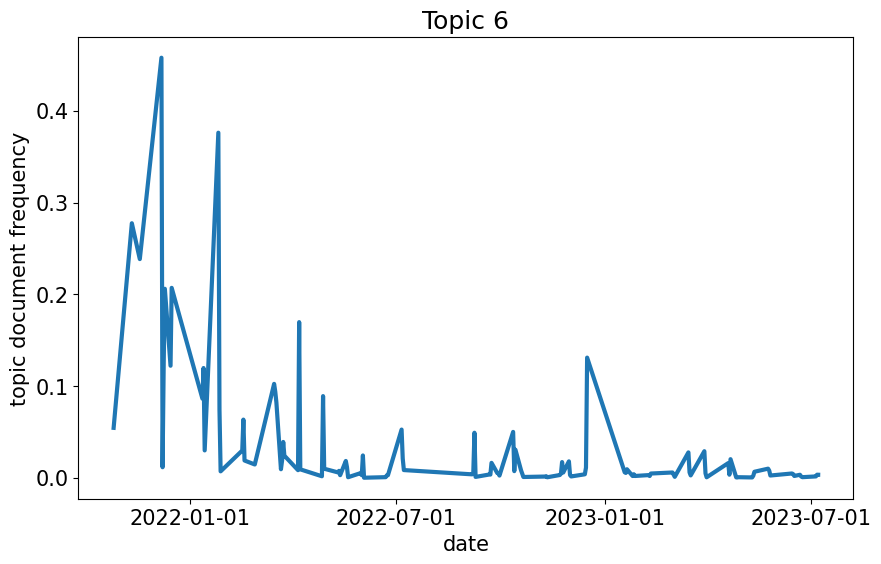

In [165]:
BT_protocols['datum']=pd.to_datetime(BT_protocols['datum'])

tickdates=pd.to_datetime(["2022-01-01", "2022-07-01", "2023-01-01", "2023-07-01"])

plt.figure(figsize=(10,6))
plt.plot(BT_protocols['datum'],lda_model.doc_topic_[:,6])
plt.xticks(tickdates)
plt.title('Topic 6')
plt.ylabel("topic document frequency")
plt.xlabel("date")

plt.show()

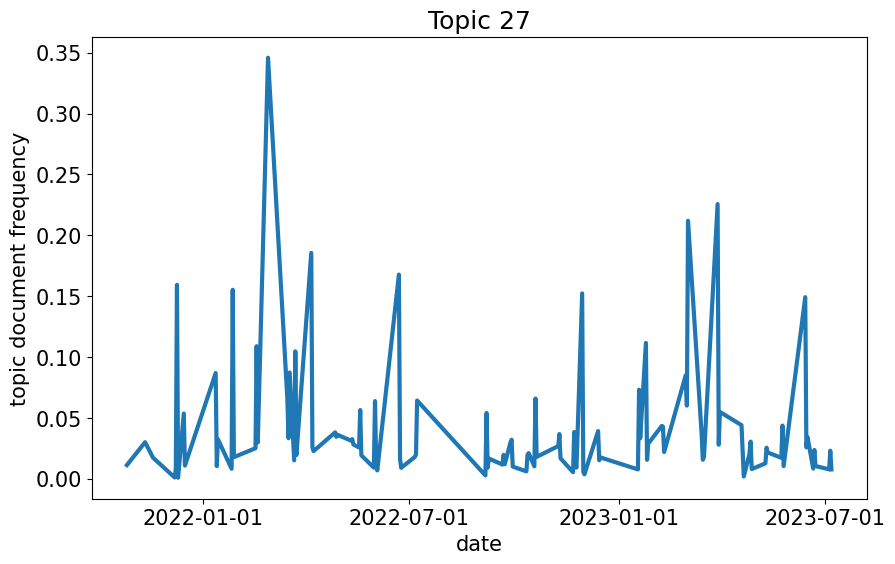

In [164]:
plt.figure(figsize=(10,6))
plt.plot(BT_protocols['datum'],lda_model.doc_topic_[:,27])
plt.xticks(tickdates)
plt.title('Topic 27')
plt.ylabel("topic document frequency")
plt.xlabel("date")

plt.show()

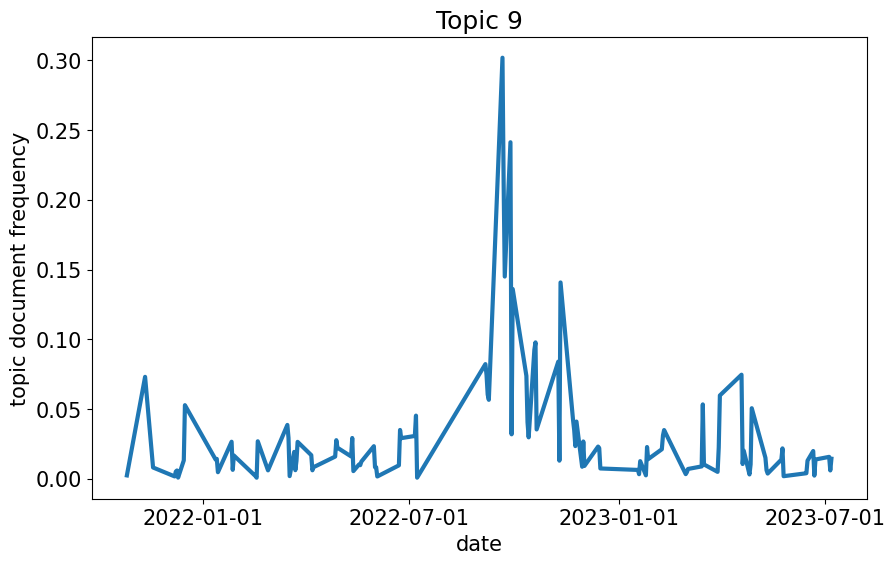

In [162]:
plt.figure(figsize=(10,6))
plt.plot(BT_protocols['datum'],lda_model.doc_topic_[:,9])
plt.xticks(tickdates)
plt.title('Topic 9')
plt.ylabel("topic document frequency")
plt.xlabel("date")

plt.show()

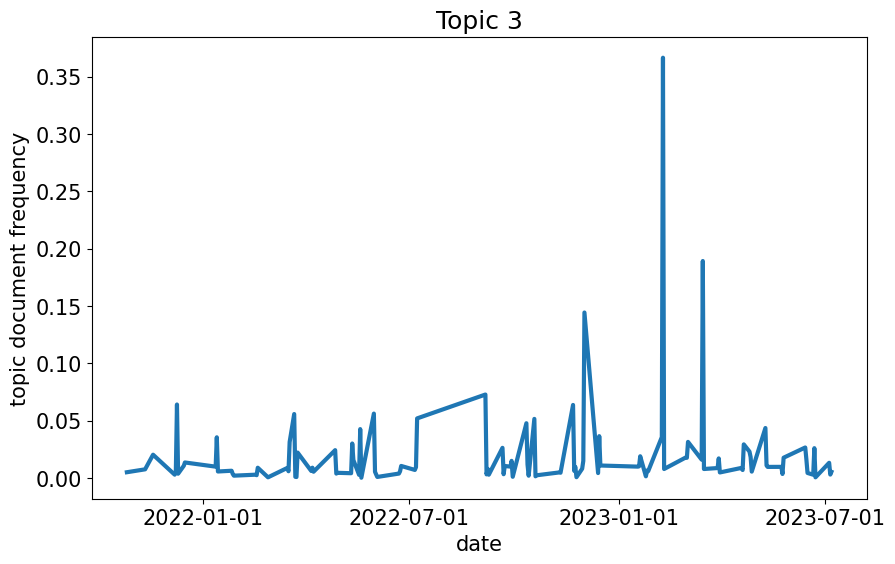

In [163]:
plt.figure(figsize=(10,6))
plt.plot(BT_protocols['datum'],lda_model.doc_topic_[:,3])
plt.xticks(tickdates)
plt.title('Topic 3')
plt.ylabel("topic document frequency")
plt.xlabel("date")

plt.show()